In [ ]:
!pip install bnlearn

  Using cached numpy-1.25.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.2 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.2 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

In [ ]:
# https://www.kaggle.com/code/vbmokin/titanic-predict-using-a-simple-bayesian-network/notebook
# https://drive.google.com/drive/folders/1XsLwVgCPIJ5QlA-t8t155cOW9XHqkXTX?usp=drive_link

In [ ]:
import seaborn as sns

In [ ]:
import bnlearn as bn

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [ ]:
train = pd.read_csv('train_titanic.csv').set_index('PassengerId')
test = pd.read_csv('test_titanic.csv').set_index('PassengerId')

In [ ]:
train.head(3)

,Survived,Pclass,Sex,SibSp,Parch,Embarked
PassengerId,,,,,,
1,0,3,male,1,0,S
2,1,1,female,1,0,C
3,1,3,female,0,0,S


In [ ]:
train.describe()

,Survived,Pclass,SibSp,Parch
count,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.523008,0.381594
std,0.486592,0.836071,1.102743,0.806057
min,0.000000,1.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,0.000000
75%,1.000000,3.000000,1.000000,0.000000
max,1.000000,3.000000,8.000000,6.000000


In [ ]:
drop_list = ['Name', 'Age', 'Cabin', 'Ticket', 'Fare']
train = train.drop(columns=drop_list)
test = test.drop(columns=drop_list)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Survived  891 non-null    int64 
 1   Pclass    891 non-null    int64 
 2   Sex       891 non-null    object
 3   SibSp     891 non-null    int64 
 4   Parch     891 non-null    int64 
 5   Embarked  889 non-null    object
dtypes: int64(4), object(2)
memory usage: 48.7+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Pclass    418 non-null    int64 
 1   Sex       418 non-null    object
 2   SibSp     418 non-null    int64 
 3   Parch     418 non-null    int64 
 4   Embarked  418 non-null    object
dtypes: int64(3), object(2)
memory usage: 19.6+ KB


## **Data Preparation**

In [ ]:
dfhot_train, dfnum_train = bn.df2onehot(train)
dfhot_test, dfnum_test = bn.df2onehot(test)


[df2onehot] >Auto detecting dtypes.


100%|██████████| 6/6 [00:00<00:00, 40.36it/s]

[df2onehot] >Set dtypes in dataframe..



[df2onehot]: 100%|██████████| 6/6 [00:00<00:00, 32.68it/s]


[df2onehot] >Total onehot features: 18

[df2onehot] >Auto detecting dtypes.


100%|██████████| 5/5 [00:00<00:00, 94.06it/s]


[df2onehot] >Set dtypes in dataframe..


[df2onehot]: 100%|██████████| 5/5 [00:00<00:00, 137.28it/s]


[df2onehot] >Total onehot features: 14


# **Creation the Bayesian network**

In [ ]:
dfnum_train

,Survived,Pclass,Sex,SibSp,Parch,Embarked
0,0,3,1,2,1,3
1,1,1,0,2,1,1
2,1,3,0,1,1,3
3,1,1,0,2,1,3
4,0,3,1,1,1,3
...,...,...,...,...,...,...
886,0,2,1,1,1,3
887,1,1,0,1,1,3
888,0,3,0,2,3,3
889,1,1,1,1,1,1


In [ ]:
dfnum_target = dfnum_train.pop('Survived')

In [ ]:
Xtrain, Xval, Ztrain, Zval = train_test_split(dfnum_train, dfnum_target, test_size=0.2, random_state=0)
valid = pd.concat([Xval, Zval], axis='columns')
dfnum = pd.concat([Xtrain, Ztrain], axis='columns')
dfnum

,Pclass,Sex,SibSp,Parch,Embarked,Survived
140,3,0,1,3,1,0
439,2,1,1,1,3,0
817,2,1,2,2,1,0
378,3,1,1,1,1,0
491,3,1,1,1,3,0
...,...,...,...,...,...,...
835,1,0,2,2,1,1
192,3,0,2,1,3,1
629,3,1,1,1,2,0
559,3,0,2,1,3,1


**Get Scores**

In [ ]:
def get_acc(model, df, col):
    # Get accuracy score by the model for the validation dataset df with target col
    pred = bn.predict(model, df, variables=[col])
    print(pred)
    acc = accuracy_score(df[col], pred[col])
    print('Accuracy -', acc)
    return acc

## **Model 1**

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


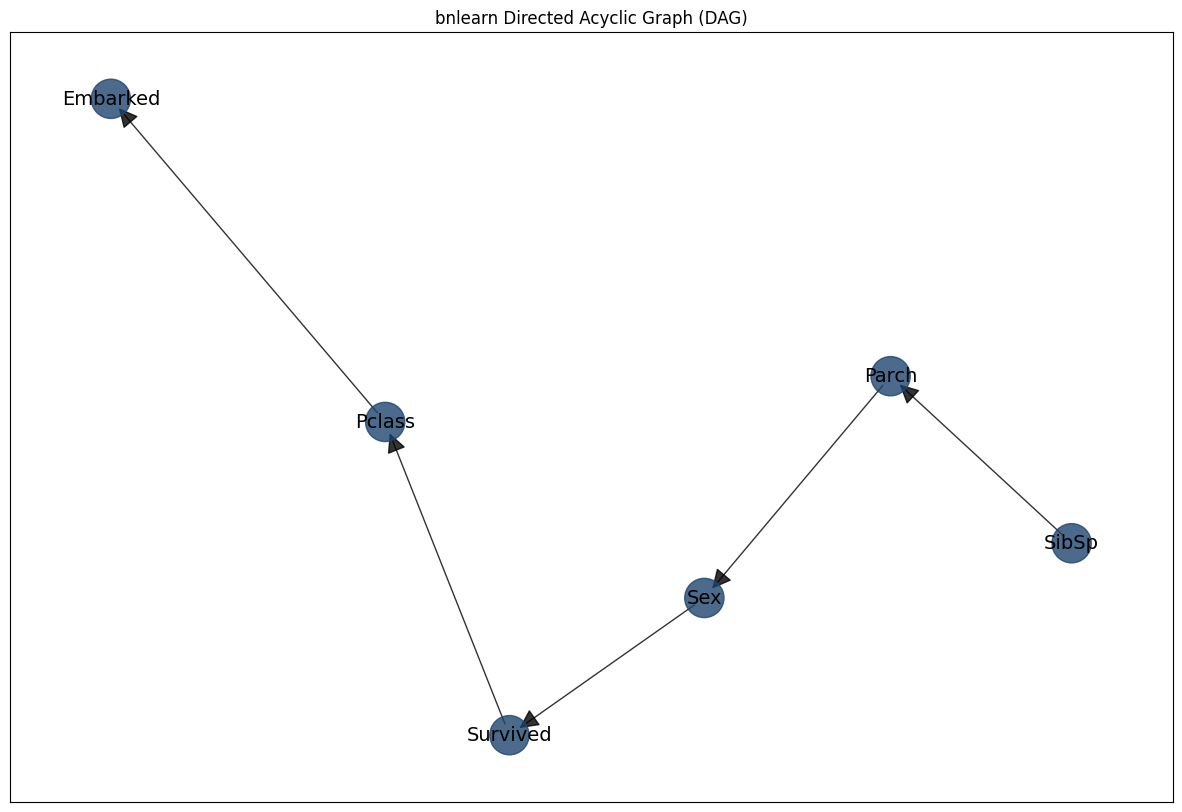

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Pclass:
+-----------+---------------------+---------------------+
| Survived  | Survived(0)         | Survived(1)         |
+-----------+---------------------+---------------------+
| Pclass(1) | 0.2477813276535321  | 0.3501509271237602  |
+-----------+---------------------+---------------------+
| Pclass(2) | 0.2594959176428825  | 0.30487278999568784 |
+-----------+---------------------+---------------------+
| Pclass(3) | 0.49272275470358534 | 0.344976282880552   |
+-----------+---------------------+---------------------+
[bnlearn] >CPD of Embarked:
+-------------+---------------------+-----+---------------------+
| Pclass      | Pclass(1)           | ... | Pclass(3)           |
+-------------+---------------------+-----+---------------------+
| Embarked(0) | 0.16953642384105

In [ ]:
%%time
# Structure learning
DAG = bn.structure_learning.fit(dfnum, methodtype='hc', root_node='Survived', bw_list_method='nodes', verbose=3)

# Plot
G = bn.plot(DAG)

# Parameter learning
model = bn.parameter_learning.fit(DAG, dfnum, verbose=3);

In [ ]:
model

{'model': <pgmpy.models.BayesianNetwork.BayesianNetwork at 0x7fe0ef5f8be0>,
 'adjmat': target    Pclass    Sex  SibSp  Parch  Embarked  Survived
 source                                                   
 Pclass     False  False  False  False      True     False
 Sex        False  False  False  False     False      True
 SibSp      False  False  False   True     False     False
 Parch      False   True  False  False     False     False
 Embarked   False  False  False  False     False     False
 Survived    True  False  False  False     False     False,
 'config': {'verbose': 3, 'method': 'bayes', 'n_jobs': -1},
 'model_edges': [('Pclass', 'Embarked'),
  ('Sex', 'Survived'),
  ('Survived', 'Pclass'),
  ('SibSp', 'Parch'),
  ('Parch', 'Sex')],
 'structure_scores': {'k2': -3176.1850309006445,
  'bic': -3209.323591016363,
  'bdeu': -3172.7649943218303,
  'bds': -3186.627937933029},
 'independence_test': None}

In [ ]:
# Get score of the model1
acc1 = get_acc(model, valid, 'Survived')

[bnlearn]> Remaining columns for inference: 5


100%|██████████| 59/59 [00:00<00:00, 147.90it/s]


     Survived         p
0           0  0.725084
1           0  0.725084
2           0  0.725084
3           1  0.662098
4           0  0.507407
..        ...       ...
174         0  0.507407
175         0  0.725084
176         1  0.662098
177         0  0.725084
178         0  0.725084

[179 rows x 2 columns]
Accuracy - 0.8156424581005587


## **Model 2**

[bnlearn] >Filter variables (nodes) on black_list..
[bnlearn] >Number of features after white/black listing: 5
[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


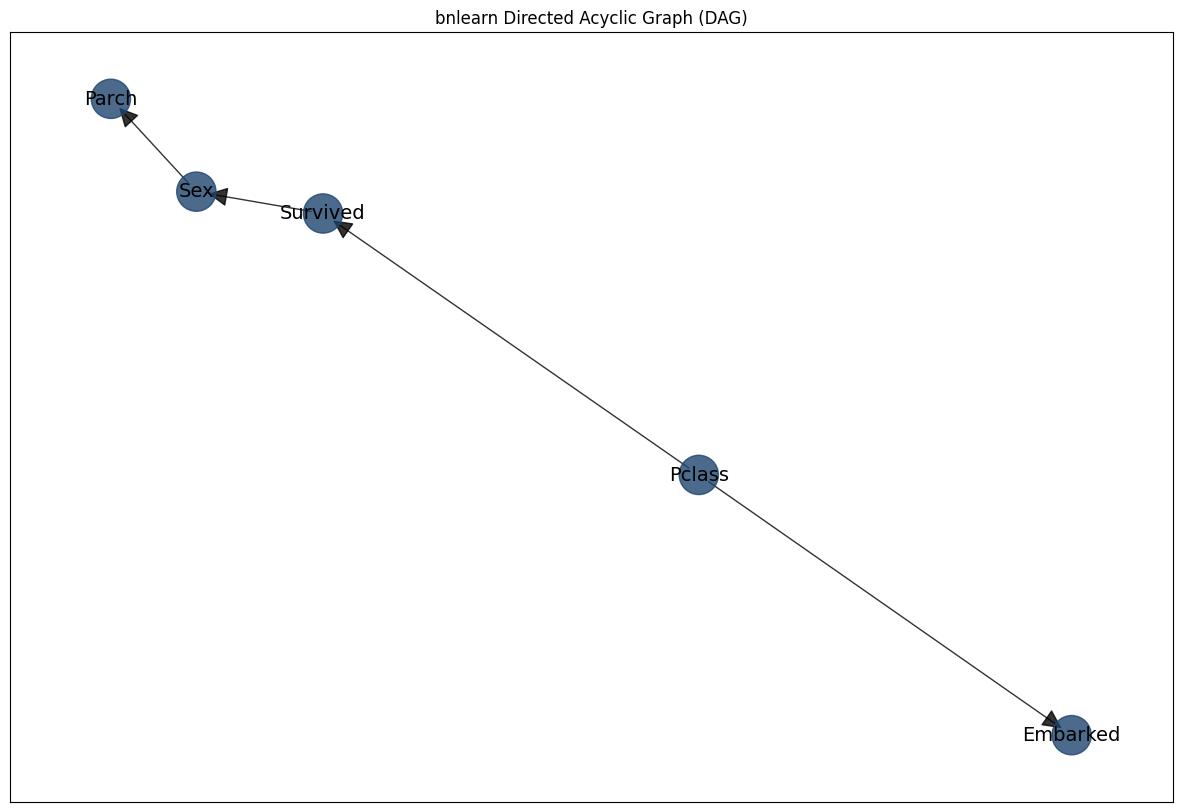

[bnlearn] >Removing columns from dataframe to make consistent with DAG [['SibSp']]
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Pclass:
+-----------+----------+
| Pclass(1) | 0.294003 |
+-----------+----------+
| Pclass(2) | 0.279984 |
+-----------+----------+
| Pclass(3) | 0.426012 |
+-----------+----------+
[bnlearn] >CPD of Embarked:
+-------------+---------------------+-----+---------------------+
| Pclass      | Pclass(1)           | ... | Pclass(3)           |
+-------------+---------------------+-----+---------------------+
| Embarked(0) | 0.16953642384105963 | ... | 0.11425959780621572 |
+-------------+---------------------+-----+---------------------+
| Embarked(1) | 0.28874172185430463 | ... | 0.1855575868372943  |
+-------------+---------------------+-----+---------------------+
| Embarked(2) | 0.16754966887417

In [ ]:
%%time
# Structure learning
DAG2 = bn.structure_learning.fit(dfnum, methodtype='hc', black_list=['SibSp'], root_node='Survived', bw_list_method='nodes', verbose=4)

# Plot
G2 = bn.plot(DAG2)

# Parameter learning
model2 = bn.parameter_learning.fit(DAG2, dfnum, verbose=4);

In [ ]:
# Score of the model2
acc2 = get_acc(model, valid.drop(columns=['SibSp']), 'Survived')

[bnlearn]> Remaining columns for inference: 4


100%|██████████| 34/34 [00:00<00:00, 189.35it/s]

     Survived         p
0           0  0.725084
1           0  0.725084
2           0  0.725084
3           1  0.662098
4           0  0.507407
..        ...       ...
174         0  0.507407
175         0  0.725084
176         1  0.662098
177         0  0.725084
178         0  0.725084

[179 rows x 2 columns]
Accuracy - 0.8156424581005587


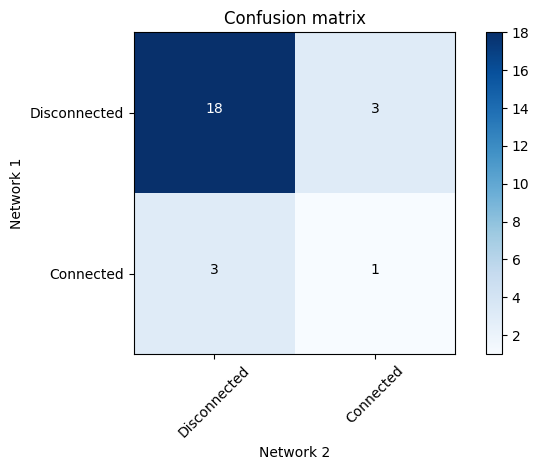

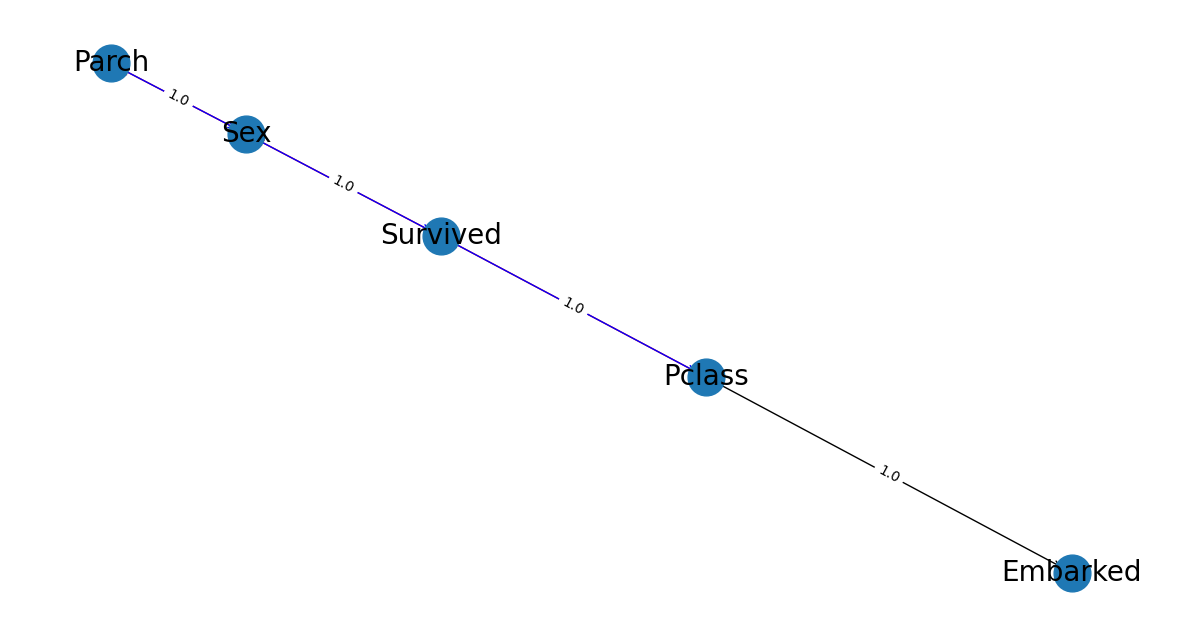

Coincidence - 0.76


In [ ]:
# Models comparing
res = bn.bnlearn.compare_networks(model, model2, figsize=(15, 8), verbose=3)
print('Coincidence -', (res[0][0, 0] + res[0][1, 1])/res[0].sum())

# **Inference from the Bayesian network**

In [ ]:
%%time
# Make inference
query = bn.inference.fit(model, variables=['Survived'], evidence={'Sex':True, 'Pclass':True})
print(query)
print(query.df)

print("-------------------------------------------------------------------------------------------------------------------------------")
# Another inference using only sex for evidence
q1 = bn.inference.fit(model, variables=['Survived'], evidence={'Sex':0})
print(q1)
print(q1.df)

# Print model
# bn.print_CPD(model)

[bnlearn] >Variable Elimination.
[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+------------+----------+
|    |   Survived |        p |
+====+============+==========+
|  0 |          0 | 0.554994 |
+----+------------+----------+
|  1 |          1 | 0.445006 |
+----+------------+----------+
+-------------+-----------------+
| Survived    |   phi(Survived) |
+=============+=================+
| Survived(0) |          0.5550 |
+-------------+-----------------+
| Survived(1) |          0.4450 |
+-------------+-----------------+
   Survived         p
0         0  0.554994
1         1  0.445006
-------------------------------------------------------------------------------------------------------------------------------
[bnlearn] >Variable Elimination.
[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+------------+----------+
|    |   Survived |        p |
+====+===========

In [ ]:
q3 = bn.inference.fit(model, variables=['Survived'], evidence={'SibSp':1,'Parch':2})
print(q3)
print(q3.df)

[bnlearn] >Variable Elimination.
[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+------------+----------+
|    |   Survived |        p |
+====+============+==========+
|  0 |          0 | 0.533356 |
+----+------------+----------+
|  1 |          1 | 0.466644 |
+----+------------+----------+
+-------------+-----------------+
| Survived    |   phi(Survived) |
+=============+=================+
| Survived(0) |          0.5334 |
+-------------+-----------------+
| Survived(1) |          0.4666 |
+-------------+-----------------+
   Survived         p
0         0  0.533356
1         1  0.466644


In [ ]:
q5 = bn.inference.fit(model, variables=['Survived'], evidence={'Pclass':True,'Embarked':2})
print(q5)
print(q5.df)

[bnlearn] >Variable Elimination.
[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+------------+----------+
|    |   Survived |        p |
+====+============+==========+
|  0 |          0 | 0.470009 |
+----+------------+----------+
|  1 |          1 | 0.529991 |
+----+------------+----------+
+-------------+-----------------+
| Survived    |   phi(Survived) |
+=============+=================+
| Survived(0) |          0.4700 |
+-------------+-----------------+
| Survived(1) |          0.5300 |
+-------------+-----------------+
   Survived         p
0         0  0.470009
1         1  0.529991


# **Prediction**

In [ ]:
Pout = bn.predict(model, df=dfnum_test, variables=['Survived'])
Pout

[bnlearn]> Remaining columns for inference: 5


100%|██████████| 84/84 [00:00<00:00, 151.15it/s]


,Survived,p
0,0,0.725084
1,0,0.507407
2,0,0.611161
3,0,0.725084
4,0,0.507407
...,...,...
413,0,0.725084
414,1,0.662098
415,0,0.725084
416,0,0.725084


In [ ]:
# Submission
submission = pd.read_csv('gender_submission.csv')
submission['Survived'] = Pout['Survived']
submission.to_csv('submission.csv', index=False)
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
